In [1]:
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools
%matplotlib inline

In [2]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

In [3]:
t0=dt.datetime(2015,2,6) # 1st start date of run
#te=dt.datetime(2016,12,1)# last start date of runfnum=18
stm=np.shape(tmask)
SiN=2.0
nlen=28
#nlen=37
dlist=[t0+dt.timedelta(days=ii*10) for ii in range(0,nlen)]

In [4]:
sdir0='/results/SalishSea/nowcast-green/'
sdir1='/results/SalishSea/hindcast/'
sdir3='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_T3/'

In [5]:
tmaskC=np.copy(tmask)
tmaskC[:,:,370:490,:12]=0
tmaskC[:,:,887:,30:70]=0

In [6]:
tlist=dlist
SiGlobalTot=dict()
SiTot=dict()
BSiTot=dict()
DiatTot=dict()
changeSiGlobalTot=dict()
for idir in (sdir0,sdir1,sdir3):
    fformat1='%d%b%y/'
    if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
        fformatT='SalishSea_1h_*_ptrc_T_%Y%m%d-*.nc'
        fformatP='SalishSea_1h_*_ptrc_T_%Y%m%d-*.nc'
    elif idir==sdir0:
        fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
        fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_grid_T.nc'
    elif idir==sdir1:
        fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
        fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
    sumSi=np.zeros((len(tlist),stm[2],stm[3]))
    sumBSi=np.zeros((len(tlist),stm[2],stm[3]))
    sumDiat=np.zeros((len(tlist),stm[2],stm[3]))
    ind=-1
    for idt0 in tlist:
        ind=ind+1
        cdir=idt0.strftime(fformat1).lower()
        iffT=idt0.strftime(fformatT)
        iffP=idt0.strftime(fformatP)
        if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
            sffT=idir+iffT
            sffP=idir+iffP
        elif idir.startswith('/results/'):
            sffT=idir+cdir+iffT
            sffP=idir+cdir+iffP
        f=nc.Dataset(glob.glob(sffT)[0])
        print(sffT)
        fP=nc.Dataset(glob.glob(sffP)[0])
        if idir==sdir0:
            e3t=np.expand_dims((1+fP.variables['sossheig'][0,:,:]/np.sum(e3t_0*tmask,1)),0)*e3t_0
        elif idir==sdir1:
            e3t=fP.variables['e3t'][:,:,:,:]
        Vol=A*e3t
        sumSi[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['silicon'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumBSi[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['biogenic_silicon'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumDiat[ind,:,:]=SiN*1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['diatoms'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
    SiGlobalTot[idir]=np.sum(np.sum(sumSi+sumBSi+sumDiat,2),1)
    SiTot[idir]=np.sum(np.sum(sumSi,2),1)
    BSiTot[idir]=np.sum(np.sum(sumBSi,2),1)
    DiatTot[idir]=np.sum(np.sum(sumDiat,2),1)
    changeSiGlobalTot[idir]=[SiGlobalTot[idir][ii+1]-SiGlobalTot[idir][ii] for ii in range(0,len(tlist)-1)]

/results/SalishSea/nowcast-green/06feb15/SalishSea_1h_20150206_20150206_ptrc_T.nc
/results/SalishSea/nowcast-green/16feb15/SalishSea_1h_20150216_20150216_ptrc_T.nc
/results/SalishSea/nowcast-green/26feb15/SalishSea_1h_20150226_20150226_ptrc_T.nc
/results/SalishSea/nowcast-green/08mar15/SalishSea_1h_20150308_20150308_ptrc_T.nc
/results/SalishSea/nowcast-green/18mar15/SalishSea_1h_20150318_20150318_ptrc_T.nc
/results/SalishSea/nowcast-green/28mar15/SalishSea_1h_20150328_20150328_ptrc_T.nc
/results/SalishSea/nowcast-green/07apr15/SalishSea_1h_20150407_20150407_ptrc_T.nc
/results/SalishSea/nowcast-green/17apr15/SalishSea_1h_20150417_20150417_ptrc_T.nc
/results/SalishSea/nowcast-green/27apr15/SalishSea_1h_20150427_20150427_ptrc_T.nc
/results/SalishSea/nowcast-green/07may15/SalishSea_1h_20150507_20150507_ptrc_T.nc
/results/SalishSea/nowcast-green/17may15/SalishSea_1h_20150517_20150517_ptrc_T.nc
/results/SalishSea/nowcast-green/27may15/SalishSea_1h_20150527_20150527_ptrc_T.nc
/results/SalishS

In [7]:
sffP

'/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_T3/SalishSea_1h_*_ptrc_T_20151103-*.nc'

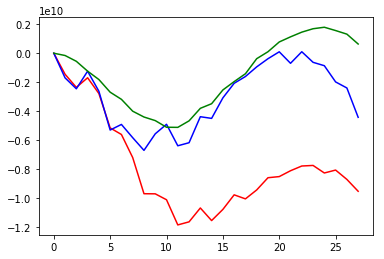

In [8]:
plt.plot(SiGlobalTot[sdir0]-SiGlobalTot[sdir0][0],'r-')
plt.plot(SiGlobalTot[sdir1]-SiGlobalTot[sdir1][0],'b-')
plt.plot(SiGlobalTot[sdir3]-SiGlobalTot[sdir3][0],'g-')